<a href="https://colab.research.google.com/github/dukei/dls-fr/blob/master/DLS-project-FR-2_PrepareDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Отбор примеров в датасет для распознавания

# Датасет

В качестве датасета нужно использовать картинки из CelebA, выровненные при помощи своей модели из задания 1. Очень желательно их еще кропнуть таким образом, чтобы нейросети поступали на вход преимущественно только лица без какого либо фона, частей тела и прочего.

Если планируете делать дополнительное задание на Identificaton rate metric, то **обязательно разбейте заранее датасет на train/val или train/val/test.** Это нужно сделать не только на уровне кода, а на уровне папок, чтобы точно знать, на каких картинках модель обучалась, а на каких нет. Лучше заранее почитайте [ноутбук с заданием](https://colab.research.google.com/drive/15zuNdOupRFnG7oE-rFj9FsjoNTK6DYn5).

Оказалось, что датасет, подготовленный для распознавания точек лица не слишком подходит для распознавания лиц. Потому что для распознавания лиц нужно набрать в тренировочный датасет для каждого человека много изображений (лучше 20+), в валидационный - тех же людей, и для каждого хотя бы 5 изображений. А для тестового вообще лучше совсем других людей, и тоже хотя бы по 5 изображений.

Мало того, для распознавания требуются фронтальные лица. А у нас в датасете есть лица в профиль или повернутые под каким-то ещё углом.

Поэтому в этом ноутбуке сделаем новый выбор файлов в датасет для распознавания.

In [1]:
import os
import gdown

# Загружаем файл с identity
if not os.path.exists('celeba_dataset/identity.txt'):
    os.makedirs('celeba_dataset', exist_ok=True)

    gdown.download("https://drive.google.com/file/d/1_ee_0u7vcNLOfNLegJRHmolfH5ICW-XS/view", 'celeba_dataset/identity.txt', fuzzy=True)

In [2]:
import pandas as pd

identity_df = pd.read_csv('celeba_dataset/identity.txt',
                           sep=' ', skipinitialspace=True,
                           names=['image_id','identity'], index_col='image_id')

identity_df

,identity
image_id,
000001.jpg,2880
000002.jpg,2937
000003.jpg,8692
000004.jpg,5805
000005.jpg,9295
...,...
202595.jpg,9761
202596.jpg,7192
202597.jpg,9852


In [15]:
import os
import kagglehub
import json

dataset_name = 'kevinpatel04/celeba-original-wild-images'
dataset_path = './celeba_dataset/'

source_dir = kagglehub.dataset_download(dataset_name)
source_dir


'/home/dukei/.cache/kagglehub/datasets/kevinpatel04/celeba-original-wild-images/versions/1'

In [16]:
def image_path_from_image_id(file_name):
    """
    Возвращает полный путь к файлу изображения по его имени.
    """

    # Предполагается, что base_dir уже указывает на корневую директорию, где находятся Part X папки
    # или что files уже содержит полные пути от base_dir
    part = ((int(file_name[:6]) - 1) // 10000) + 1
    return os.path.join(source_dir, f"Part {part}", f"Part {part}", file_name)


In [5]:
num_distinct_identities_overall = identity_df['identity'].nunique()
print(f"Total number of distinct identities in the original identity_df: {num_distinct_identities_overall}")

Total number of distinct identities in the original identity_df: 10177


# Фильтрация фронтальных лиц

По расположению ключевых точек лица можно с высокой степенью уверенности сказать, это анфас или профиль. Попробуем по нашим предсказанным лэндмаркам отфильтровать лица.

In [6]:
import os
import gdown
import pandas as pd

landmarks_file_path = 'celeba_dataset/fr/predicted_landmarks.csv'

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(landmarks_file_path), exist_ok=True)

# Load the predicted landmarks into a DataFrame
predicted_landmarks_df = pd.read_csv(landmarks_file_path, index_col='image_id')

print("Predicted landmarks data loaded successfully.")
predicted_landmarks_df.head()

Predicted landmarks data loaded successfully.


,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y
image_id,,,,,,,,,,
000001.jpg,162.31577,180.62500,240.91226,170.87500,196.70174,244.00000,186.87717,268.37500,265.47366,258.62500
000002.jpg,139.50000,203.50000,216.00000,203.50000,162.00000,253.00000,144.00000,289.00000,220.50000,284.50000
000003.jpg,242.72728,103.75000,260.30304,103.75000,262.06060,121.25000,233.93940,133.50000,248.00002,135.25000
000004.jpg,800.47620,515.76560,963.14290,527.31250,916.66670,677.42190,754.00006,746.70306,905.04767,746.70306
000005.jpg,271.81250,166.84299,324.62500,158.85951,295.57812,172.16528,282.37500,212.08264,321.98438,206.76033


Для экономии усилий мы дали эту задачу выполнить Gemini. И она под нашим чутким руководством с этим справилась.

## Define Frontal Face Detection Logic

### Subtask:
Implement a function to determine if a face is frontal based on the symmetry of key facial landmarks (nose relative to eyes and mouth). This function will take landmark coordinates as input and return a boolean indicating if the face is frontal.


**Reasoning**:
To implement the frontal face detection logic, I need to define a Python function `is_frontal_face` that takes landmark coordinates as input. This function will then perform calculations for eye and mouth mid-points, and check for symmetry of the nose relative to these mid-points using defined thresholds.



In [7]:
import numpy as np

def is_frontal_face(lefteye_x, lefteye_y, righteye_x, righteye_y, nose_x, nose_y, leftmouth_x, leftmouth_y, rightmouth_x, rightmouth_y):
    """
    Determines if a face is frontal based on the symmetry of key facial landmarks.

    Args:
        lefteye_x, lefteye_y: Coordinates of the left eye.
        righteye_x, righteye_y: Coordinates of the right eye.
        nose_x, nose_y: Coordinates of the nose.
        leftmouth_x, leftmouth_y: Coordinates of the left mouth corner.
        rightmouth_x, rightmouth_y: Coordinates of the right mouth corner.

    Returns:
        bool: True if the face is considered frontal, False otherwise.
    """

    # 1. Calculate mid-point between eyes
    eye_mid_x = (lefteye_x + righteye_x) / 2
    eye_mid_y = (lefteye_y + righteye_y) / 2

    # 2. Calculate mid-point between mouth corners
    mouth_mid_x = (leftmouth_x + rightmouth_x) / 2
    mouth_mid_y = (leftmouth_y + rightmouth_y) / 2

    # Calculate distance between eyes for threshold scaling
    eye_distance = np.sqrt((righteye_x - lefteye_x)**2 + (righteye_y - lefteye_y)**2)
    # Define a relative threshold for symmetry checks
    symmetry_threshold = 0.15 * eye_distance # 15% of inter-eye distance

    # 3. Check if nose_x is approximately centered horizontally between eye and mouth mid-points
    # The ideal nose_x should be very close to the average of eye_mid_x and mouth_mid_x
    horizontal_symmetry_check = abs(nose_x - ((eye_mid_x + mouth_mid_x) / 2)) < symmetry_threshold

    # 4. Check if nose_y is between eye_mid_y and mouth_mid_y
    # The nose should generally be below the eyes and above the mouth
    vertical_position_check_nose_below_eyes = nose_y > min(lefteye_y, righteye_y)
    vertical_position_check_nose_above_mouth = nose_y < max(leftmouth_y, rightmouth_y)

    # A more robust check for vertical alignment: nose_y should be between eye_mid_y and mouth_mid_y
    vertical_symmetry_check = (nose_y > eye_mid_y - symmetry_threshold) and (nose_y < mouth_mid_y + symmetry_threshold)

    # Combine checks. A face is frontal if it meets both horizontal and vertical symmetry criteria.
    return horizontal_symmetry_check and vertical_symmetry_check and vertical_position_check_nose_below_eyes and vertical_position_check_nose_above_mouth

print("Function 'is_frontal_face' defined.")

Function 'is_frontal_face' defined.


**Reasoning**:
Now that the `is_frontal_face` function is defined, I need to apply it to each row of the `predicted_landmarks_df` to determine which faces are frontal and store this boolean result in a new column named `is_frontal`.



In [8]:
predicted_landmarks_df['is_frontal'] = predicted_landmarks_df.apply(lambda row: is_frontal_face(
    row['lefteye_x'], row['lefteye_y'],
    row['righteye_x'], row['righteye_y'],
    row['nose_x'], row['nose_y'],
    row['leftmouth_x'], row['leftmouth_y'],
    row['rightmouth_x'], row['rightmouth_y']
), axis=1)

print("Added 'is_frontal' column to predicted_landmarks_df.")
predicted_landmarks_df.head()

Added 'is_frontal' column to predicted_landmarks_df.


,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,is_frontal
image_id,,,,,,,,,,,
000001.jpg,162.31577,180.62500,240.91226,170.87500,196.70174,244.00000,186.87717,268.37500,265.47366,258.62500,False
000002.jpg,139.50000,203.50000,216.00000,203.50000,162.00000,253.00000,144.00000,289.00000,220.50000,284.50000,False
000003.jpg,242.72728,103.75000,260.30304,103.75000,262.06060,121.25000,233.93940,133.50000,248.00002,135.25000,False
000004.jpg,800.47620,515.76560,963.14290,527.31250,916.66670,677.42190,754.00006,746.70306,905.04767,746.70306,False
000005.jpg,271.81250,166.84299,324.62500,158.85951,295.57812,172.16528,282.37500,212.08264,321.98438,206.76033,True


## Filter for Frontal Faces

### Subtask:
Apply the frontal face detection logic to the loaded landmarks DataFrame to filter out non-frontal faces. This will result in a new DataFrame, `predicted_frontal_landmarks_df`, containing only frontal-facing image landmarks.


**Reasoning**:
To filter for frontal faces, I will select rows from `predicted_landmarks_df` where the `is_frontal` column is True and store them in a new DataFrame, then display its head to confirm the filtering.



In [9]:
predicted_frontal_landmarks_df = predicted_landmarks_df[predicted_landmarks_df['is_frontal'] == True]
print("Filtered predicted_frontal_landmarks_df created successfully.")
predicted_frontal_landmarks_df.head()

Filtered predicted_frontal_landmarks_df created successfully.


,lefteye_x,lefteye_y,righteye_x,righteye_y,nose_x,nose_y,leftmouth_x,leftmouth_y,rightmouth_x,rightmouth_y,is_frontal
image_id,,,,,,,,,,,
000005.jpg,271.81250,166.84299,324.62500,158.85951,295.57812,172.16528,282.37500,212.08264,321.98438,206.76033,True
000007.jpg,125.44349,194.21875,200.88696,185.90625,158.97392,239.93750,138.01740,273.18750,196.69566,269.03125,True
000008.jpg,276.80370,197.89062,339.60745,201.81250,296.42987,248.87500,272.87848,280.25000,331.75700,280.25000,True
000010.jpg,178.00854,212.43752,255.85469,203.81252,225.58119,255.56252,195.30770,294.37500,268.82904,281.43750,True
000011.jpg,202.34483,129.50000,247.65518,119.50000,232.55173,157.00000,214.93105,174.50000,252.68967,167.00000,True


## Save Frontal Landmarks

### Subtask:
Save the filtered frontal face landmarks DataFrame (`predicted_frontal_landmarks_df`) to a new CSV file named `predicted_frontal_landmarks.csv` in the `celeba_dataset/fr/` directory.


**Reasoning**:
To complete the subtask, I will save the `predicted_frontal_landmarks_df` DataFrame to a CSV file in the specified directory, ensuring the index is included and providing a confirmation message.



In [10]:
output_dir = 'celeba_dataset/fr/'
os.makedirs(output_dir, exist_ok=True)

output_file_path = os.path.join(output_dir, 'predicted_frontal_landmarks.csv')
predicted_frontal_landmarks_df.to_csv(output_file_path, index=True)

print(f"Filtered frontal landmarks {len(predicted_frontal_landmarks_df)} saved to: {output_file_path}")

Filtered frontal landmarks 136315 saved to: celeba_dataset/fr/predicted_frontal_landmarks.csv


## Final Task

### Subtask:
Confirm the creation of `predicted_frontal_landmarks.csv` and report the total number of frontal faces found in the dataset.


## Summary:

### Q&A
*   The creation of `predicted_frontal_landmarks.csv` has been confirmed. The file was successfully saved to `celeba_dataset/fr/predicted_frontal_landmarks.csv`.
*   The total number of frontal faces found in the dataset was not explicitly reported in the provided solving process. This number can be derived from the row count of the `predicted_frontal_landmarks_df` DataFrame.

### Data Analysis Key Findings
*   The facial landmark data from `celeba_dataset/fr/predicted_landmarks.csv` was successfully loaded into a Pandas DataFrame named `predicted_landmarks_df`. The file was found locally, so no download was initiated.
*   A custom Python function, `is_frontal_face`, was implemented to classify faces as frontal based on the symmetry of key facial landmarks (eyes, nose, and mouth).
*   This function calculates mid-points for eyes and mouth and checks if the nose's x-coordinate is horizontally centered between these mid-points within a `symmetry_threshold` defined as 15% of the inter-eye distance. It also verifies vertical alignment of the nose relative to the eyes and mouth.
*   A new column, `is_frontal`, was added to the `predicted_landmarks_df`, indicating whether each face satisfies the defined frontal criteria.
*   A new DataFrame, `predicted_frontal_landmarks_df`, was created by filtering `predicted_landmarks_df` to include only rows where `is_frontal` was `True`.
*   The `predicted_frontal_landmarks_df` was successfully saved as a CSV file named `predicted_frontal_landmarks.csv` in the `celeba_dataset/fr/` directory, including the `image_id` as an index.



In [11]:
identity_frontal_df = identity_df[identity_df.index.isin(predicted_frontal_landmarks_df.index)].copy()

print("DataFrame 'identity_frontal_df' created successfully with only frontal images.")
print(f"Total images in identity_frontal_df: {len(identity_frontal_df)}")
print(f"Unique identities in identity_frontal_df: {identity_frontal_df['identity'].nunique()}")
identity_frontal_df.head()

DataFrame 'identity_frontal_df' created successfully with only frontal images.
Total images in identity_frontal_df: 136315
Unique identities in identity_frontal_df: 10098


,identity
image_id,
000005.jpg,9295
000007.jpg,9040
000008.jpg,6369
000010.jpg,612
000011.jpg,2807


Таким образом, у нас осталось всего 136315 изображений. Проверим, как они выглядят

Random Frontal Images:
045867.jpg: /home/dukei/.cache/kagglehub/datasets/kevinpatel04/celeba-original-wild-images/versions/1/Part 5/Part 5/045867.jpg
105600.jpg: /home/dukei/.cache/kagglehub/datasets/kevinpatel04/celeba-original-wild-images/versions/1/Part 11/Part 11/105600.jpg
150268.jpg: /home/dukei/.cache/kagglehub/datasets/kevinpatel04/celeba-original-wild-images/versions/1/Part 16/Part 16/150268.jpg
109947.jpg: /home/dukei/.cache/kagglehub/datasets/kevinpatel04/celeba-original-wild-images/versions/1/Part 11/Part 11/109947.jpg

Random Non-Frontal Images:
174839.jpg: /home/dukei/.cache/kagglehub/datasets/kevinpatel04/celeba-original-wild-images/versions/1/Part 18/Part 18/174839.jpg
071672.jpg: /home/dukei/.cache/kagglehub/datasets/kevinpatel04/celeba-original-wild-images/versions/1/Part 8/Part 8/071672.jpg
191913.jpg: /home/dukei/.cache/kagglehub/datasets/kevinpatel04/celeba-original-wild-images/versions/1/Part 20/Part 20/191913.jpg
019280.jpg: /home/dukei/.cache/kagglehub/datasets/

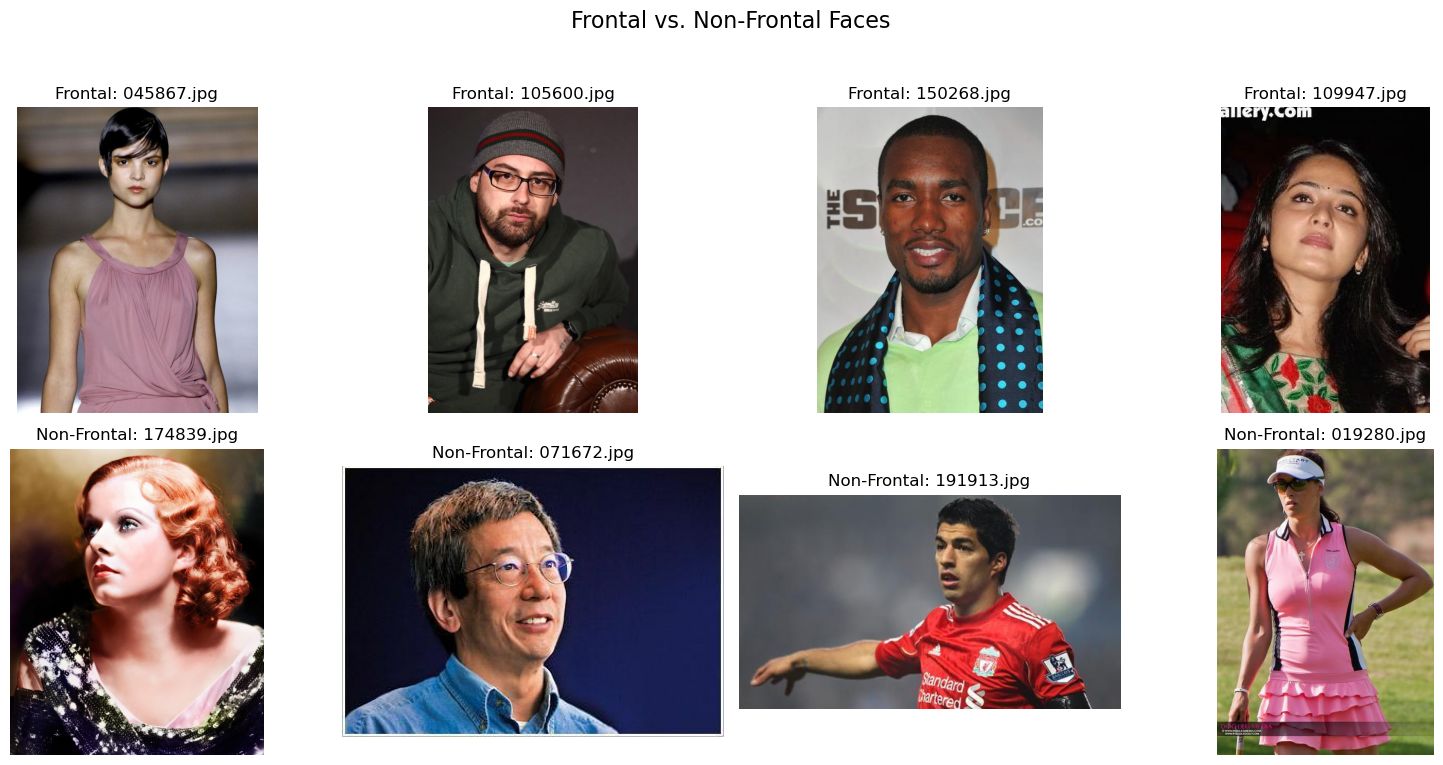

In [30]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import os

# Get 4 random frontal image IDs
random_frontal_image_ids = predicted_frontal_landmarks_df.sample(n=4).index.tolist()

# Get all non-frontal image IDs
non_frontal_image_ids = predicted_landmarks_df.index.difference(predicted_frontal_landmarks_df.index)

# Get 4 random non-frontal image IDs
random_non_frontal_image_ids = np.random.choice(non_frontal_image_ids, size=4, replace=False).tolist()

print("Random Frontal Images:")
for image_id in random_frontal_image_ids:
    image_path = image_path_from_image_id(image_id)
    print(f"{image_id}: {image_path}")

print("\nRandom Non-Frontal Images:")
for image_id in random_non_frontal_image_ids:
    image_path = image_path_from_image_id(image_id)
    print(f"{image_id}: {image_path}")

# Display images
fig, axes = plt.subplots(2, 4, figsize=(16, 8)) # 2 rows, 4 columns
fig.suptitle('Frontal vs. Non-Frontal Faces', fontsize=16)

# Display frontal images
for i, image_id in enumerate(random_frontal_image_ids):
    image_path = image_path_from_image_id(image_id)
    img = Image.open(image_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Frontal: {image_id}")
    axes[0, i].axis('off')

# Display non-frontal images
for i, image_id in enumerate(random_non_frontal_image_ids):
    image_path = image_path_from_image_id(image_id)
    img = Image.open(image_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Non-Frontal: {image_id}")
    axes[1, i].axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Действительно, видно, что в датасет включены фронтальные картинки, а картинки, в которых нос недостаточно посередине между глаз и ртом, не включены.

# Создание датасетов

Теперь надо создать датасеты из личностей с достаточным числом изображений. Посмотрим, есть ли у нас вообще такие люди

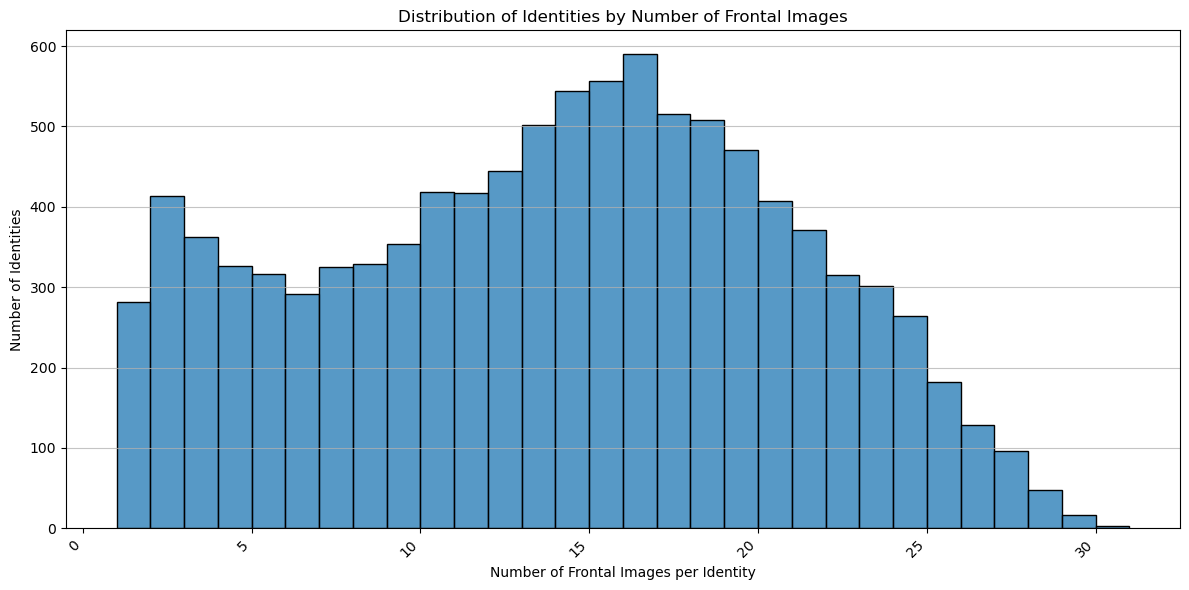

Total unique identities with frontal images: 10098
Identities with the most frontal images:
identity
3600    30
6343    30
8789    30
3826    29
5069    29
1245    29
4972    29
1264    29
3340    29
9962    29
Name: count, dtype: int64


In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the number of frontal images for each identity
frontal_image_counts_per_identity = identity_frontal_df['identity'].value_counts()

# Create a histogram to visualize the distribution
plt.figure(figsize=(12, 6))
sns.histplot(frontal_image_counts_per_identity, bins=range(1, frontal_image_counts_per_identity.max() + 2), kde=False)
plt.title('Distribution of Identities by Number of Frontal Images')
plt.xlabel('Number of Frontal Images per Identity')
plt.ylabel('Number of Identities')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()

print(f"Total unique identities with frontal images: {len(frontal_image_counts_per_identity)}")
print(f"Identities with the most frontal images:\n{frontal_image_counts_per_identity.head(10)}")

In [19]:
num_identities_5_plus_frontal = len(frontal_image_counts_per_identity[frontal_image_counts_per_identity >= 5])
num_identities_10_plus_frontal = len(frontal_image_counts_per_identity[frontal_image_counts_per_identity >= 10])
num_identities_15_plus_frontal = len(frontal_image_counts_per_identity[frontal_image_counts_per_identity >= 15])
num_identities_20_plus_frontal = len(frontal_image_counts_per_identity[frontal_image_counts_per_identity >= 20])
num_identities_25_plus_frontal = len(frontal_image_counts_per_identity[frontal_image_counts_per_identity >= 25])

print(f"Number of identities with 5+ frontal images: {num_identities_5_plus_frontal}")
print(f"Number of identities with 10+ frontal images: {num_identities_10_plus_frontal}")
print(f"Number of identities with 15+ frontal images: {num_identities_15_plus_frontal}")
print(f"Number of identities with 20+ frontal images: {num_identities_20_plus_frontal}")
print(f"Number of identities with 25+ frontal images: {num_identities_25_plus_frontal}")

Number of identities with 5+ frontal images: 8714
Number of identities with 10+ frontal images: 7099
Number of identities with 15+ frontal images: 4773
Number of identities with 20+ frontal images: 2131
Number of identities with 25+ frontal images: 473


Большая удача, людей достаточно. Но придется взять всех с 20+ изображений, уже не до дополнительной фильтрации.

# Делаем датасет из людей с 25+ изображений

In [20]:
import pandas as pd
import numpy as np
import os

# 1. Identify identities with 25 or more frontal images
identities_25_plus_frontal = frontal_image_counts_per_identity[frontal_image_counts_per_identity >= 25].index.tolist()
print(f"Number of identities with 25+ frontal images: {len(identities_25_plus_frontal)}")

# Initialize empty lists to store images for the new train and validation sets
train_25_frontal_images_list = []
valid_25_frontal_images_list = []

# 2. Iterate through identified identities and split images
for identity in identities_25_plus_frontal:
    # Get all frontal images for this identity
    all_frontal_images_for_identity = identity_frontal_df[identity_frontal_df['identity'] == identity]

    # Ensure we have at least 5 images for validation
    if len(all_frontal_images_for_identity) >= 5:
        # Randomly select 5 images for the new validation set
        valid_frontal_images = all_frontal_images_for_identity.sample(n=5, random_state=42)
        valid_25_frontal_images_list.append(valid_frontal_images)

        # Remaining images for the new training set
        train_frontal_images = all_frontal_images_for_identity.drop(valid_frontal_images.index)
        train_25_frontal_images_list.append(train_frontal_images)

# 3. Consolidate into DataFrames
if train_25_frontal_images_list:
    train_25_frontal_df = pd.concat(train_25_frontal_images_list)
else:
    train_25_frontal_df = pd.DataFrame()

if valid_25_frontal_images_list:
    valid_25_frontal_df = pd.concat(valid_25_frontal_images_list)
else:
    valid_25_frontal_df = pd.DataFrame()

print(f"New Train Frontal Dataset (25+): {len(train_25_frontal_df)} images, {train_25_frontal_df['identity'].nunique()} unique identities")
print(f"New Validation Frontal Dataset (25+): {len(valid_25_frontal_df)} images, {valid_25_frontal_df['identity'].nunique()} unique identities")

# 4. Save the new datasets
output_dir = 'celeba_dataset/fr/'
os.makedirs(output_dir, exist_ok=True)

train_25_frontal_df.to_csv(os.path.join(output_dir, 'train_25_frontal_df.csv'), index=True)
valid_25_frontal_df.to_csv(os.path.join(output_dir, 'valid_25_frontal_df.csv'), index=True)

print(f"train_25_frontal_df.csv saved to {output_dir}")
print(f"valid_25_frontal_df.csv saved to {output_dir}")

print("\n--- Checking for image_id overlaps within 25+ frontal split ---")
new_train_frontal_images_set = set(train_25_frontal_df.index)
new_val_frontal_images_set = set(valid_25_frontal_df.index)
overlap_train_val_25_frontal = len(new_train_frontal_images_set.intersection(new_val_frontal_images_set))
print(f"Overlap between new train_25_frontal_df and valid_25_frontal_df: {overlap_train_val_25_frontal} images")

if overlap_train_val_25_frontal == 0:
    print("No image overlaps detected between new train and validation frontal datasets. Success!")
else:
    print("WARNING: Image overlaps detected between new frontal datasets.")

Number of identities with 25+ frontal images: 473
New Train Frontal Dataset (25+): 10001 images, 473 unique identities
New Validation Frontal Dataset (25+): 2365 images, 473 unique identities
train_25_frontal_df.csv saved to celeba_dataset/fr/
valid_25_frontal_df.csv saved to celeba_dataset/fr/

--- Checking for image_id overlaps within 25+ frontal split ---
Overlap between new train_25_frontal_df and valid_25_frontal_df: 0 images
No image overlaps detected between new train and validation frontal datasets. Success!


 # Делаем датасет из людей с 20+ изображений

In [21]:
import pandas as pd
import numpy as np
import os

# 1. Identify identities with 20 or more frontal images
identities_20_plus_frontal = frontal_image_counts_per_identity[frontal_image_counts_per_identity >= 20].index.tolist()
print(f"Number of identities with 20+ frontal images: {len(identities_20_plus_frontal)}")

# Initialize empty lists to store images for the new train and validation sets
train_20_frontal_images_list = []
valid_20_frontal_images_list = []

# 2. Iterate through identified identities and split images
for identity in identities_20_plus_frontal:
    # Get all frontal images for this identity
    all_frontal_images_for_identity = identity_frontal_df[identity_frontal_df['identity'] == identity]

    # Ensure we have at least 5 images for validation
    if len(all_frontal_images_for_identity) >= 5:
        # Randomly select 5 images for the new validation set
        valid_frontal_images = all_frontal_images_for_identity.sample(n=5, random_state=42)
        valid_20_frontal_images_list.append(valid_frontal_images)

        # Remaining images for the new training set
        train_frontal_images = all_frontal_images_for_identity.drop(valid_frontal_images.index)
        train_20_frontal_images_list.append(train_frontal_images)

# 3. Consolidate into DataFrames
if train_20_frontal_images_list:
    train_20_frontal_df = pd.concat(train_20_frontal_images_list)
else:
    train_20_frontal_df = pd.DataFrame()

if valid_20_frontal_images_list:
    valid_20_frontal_df = pd.concat(valid_20_frontal_images_list)
else:
    valid_20_frontal_df = pd.DataFrame()

print(f"New Train Frontal Dataset (20+): {len(train_20_frontal_df)} images, {train_20_frontal_df['identity'].nunique()} unique identities")
print(f"New Validation Frontal Dataset (20+): {len(valid_20_frontal_df)} images, {valid_20_frontal_df['identity'].nunique()} unique identities")

# 4. Save the new datasets
output_dir = 'celeba_dataset/fr/'
os.makedirs(output_dir, exist_ok=True)

train_20_frontal_df.to_csv(os.path.join(output_dir, 'train_20_frontal_df.csv'), index=True)
valid_20_frontal_df.to_csv(os.path.join(output_dir, 'valid_20_frontal_df.csv'), index=True)

print(f"train_20_frontal_df.csv saved to {output_dir}")
print(f"valid_20_frontal_df.csv saved to {output_dir}")

print("\n--- Checking for image_id overlaps within 20+ frontal split ---")
new_train_frontal_images_set = set(train_20_frontal_df.index)
new_val_frontal_images_set = set(valid_20_frontal_df.index)
overlap_train_val_20_frontal = len(new_train_frontal_images_set.intersection(new_val_frontal_images_set))
print(f"Overlap between new train_20_frontal_df and valid_20_frontal_df: {overlap_train_val_20_frontal} images")

if overlap_train_val_20_frontal == 0:
    print("No image overlaps detected between new train and validation frontal datasets. Success!")
else:
    print("WARNING: Image overlaps detected between new frontal datasets.")

Number of identities with 20+ frontal images: 2131
New Train Frontal Dataset (20+): 37831 images, 2131 unique identities
New Validation Frontal Dataset (20+): 10655 images, 2131 unique identities
train_20_frontal_df.csv saved to celeba_dataset/fr/
valid_20_frontal_df.csv saved to celeba_dataset/fr/

--- Checking for image_id overlaps within 20+ frontal split ---
Overlap between new train_20_frontal_df and valid_20_frontal_df: 0 images
No image overlaps detected between new train and validation frontal datasets. Success!


# Делаем тестовые датасеты

Делаем их из людей, которые не попали в тренировочный и валидационный датасеты, и, кроме того, имеющих 5+ изображений

In [22]:
import pandas as pd
import numpy as np
import os

def create_frontal_test_dataset(train_df_obj, valid_df_obj, test_df_filename):
    """
    Creates a test dataset of frontal images for identities that have at least 5 frontal images,
    excluding those already used in specified train and validation sets.

    Args:
        train_df_obj (pandas.DataFrame): The DataFrame for the corresponding train set.
        valid_df_obj (pandas.DataFrame): The DataFrame for the corresponding validation set.
        test_df_filename (str): Desired filename for the output test CSV (e.g., 'test_25_frontal_df.csv').

    Returns:
        pandas.DataFrame: The created test DataFrame.
    """

    print(f"\n--- Creating {test_df_filename} ---")

    # Use the passed DataFrame objects directly
    train_df_curr = train_df_obj
    valid_df_curr = valid_df_obj

    if train_df_curr is None or valid_df_curr is None:
        print(f"Error: Corresponding train_df or valid_df object not provided.")
        return pd.DataFrame()

    train_identities_used = set(train_df_curr['identity'].unique())
    valid_identities_used = set(valid_df_curr['identity'].unique())
    all_used_identities_for_this_split = train_identities_used.union(valid_identities_used)

    # Collect ALL images used in this specific train/val split
    all_images_used_in_current_train_val = set(train_df_curr.index.tolist()).union(set(valid_df_curr.index.tolist()))

    # Pre-filter the main identity_frontal_df to exclude all images already used in the current train/val
    # This operation is done once for each test set generation.
    available_frontal_images_not_in_train_val = identity_frontal_df[~identity_frontal_df.index.isin(all_images_used_in_current_train_val)].copy()

    # 1. Get all identities with 5+ frontal images to form the base pool for test identities
    base_potential_identities = frontal_image_counts_per_identity[frontal_image_counts_per_identity >= 5].index.tolist()

    # 3. Filter potential test identities: from the base_potential_identities pool, exclude those already used
    potential_test_identities = [
        id for id in base_potential_identities
        if id not in all_used_identities_for_this_split
    ]
    print(f"Number of potential test identities for {test_df_filename} (from 5+ frontal, unused in train/val): {len(potential_test_identities)}")

    test_images_list = []
    test_identities_collected = set()
    images_per_test_identity = 5

    # Iterate through potential test identities and select images
    for identity in potential_test_identities:
        # Get available frontal images for this specific identity from the pre-filtered DataFrame
        available_images_for_this_identity = available_frontal_images_not_in_train_val[available_frontal_images_not_in_train_val['identity'] == identity]

        if len(available_images_for_this_identity) >= images_per_test_identity:
            selected_images = available_images_for_this_identity.sample(n=images_per_test_identity, random_state=42)
            test_images_list.append(selected_images)
            test_identities_collected.add(identity)

    if test_images_list:
        test_df = pd.concat(test_images_list)
    else:
        test_df = pd.DataFrame()

    print(f"New Test Frontal Dataset (from unused 5+ frontal): {len(test_df)} images, {len(test_identities_collected)} unique identities.")

    # Save the dataset
    output_dir = 'celeba_dataset/fr/'
    os.makedirs(output_dir, exist_ok=True)
    output_file_path = os.path.join(output_dir, test_df_filename)
    test_df.to_csv(output_file_path, index=True)
    print(f"{test_df_filename} saved to {output_dir}")

    print("--- Checking for image_id overlaps within this test split ---")
    new_test_images_set = set(test_df.index)
    # The overlap check should still be against `all_images_used_in_current_train_val`
    overlap_test_train_val = len(new_test_images_set.intersection(all_images_used_in_current_train_val))
    print(f"Overlap between {test_df_filename} and its train/val sets: {overlap_test_train_val} images")

    if overlap_test_train_val == 0:
        print("No image overlaps detected between this test set and its train/val datasets. Success!")
    else:
        print("WARNING: Image overlaps detected between this test set and its train/val datasets.")

    return test_df


# --- Create test_25_frontal_df.csv ---
test_25_frontal_df = create_frontal_test_dataset(
    train_df_obj=train_25_frontal_df,
    valid_df_obj=valid_25_frontal_df,
    test_df_filename='test_25_frontal_df.csv'
)

# --- Create test_20_frontal_df.csv ---
test_20_frontal_df = create_frontal_test_dataset(
    train_df_obj=train_20_frontal_df,
    valid_df_obj=valid_20_frontal_df,
    test_df_filename='test_20_frontal_df.csv'
)



--- Creating test_25_frontal_df.csv ---
Number of potential test identities for test_25_frontal_df.csv (from 5+ frontal, unused in train/val): 8241
New Test Frontal Dataset (from unused 5+ frontal): 41205 images, 8241 unique identities.
test_25_frontal_df.csv saved to celeba_dataset/fr/
--- Checking for image_id overlaps within this test split ---
Overlap between test_25_frontal_df.csv and its train/val sets: 0 images
No image overlaps detected between this test set and its train/val datasets. Success!

--- Creating test_20_frontal_df.csv ---
Number of potential test identities for test_20_frontal_df.csv (from 5+ frontal, unused in train/val): 6583
New Test Frontal Dataset (from unused 5+ frontal): 32915 images, 6583 unique identities.
test_20_frontal_df.csv saved to celeba_dataset/fr/
--- Checking for image_id overlaps within this test split ---
Overlap between test_20_frontal_df.csv and its train/val sets: 0 images
No image overlaps detected between this test set and its train/val d